<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/10xCRISPR/10xCRISPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Mon Jul 12 22:56:54 UTC 2021


In [2]:
!rm -rf BMGP_2020
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 859, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 859 (delta 16), reused 0 (delta 0), pack-reused 817
Receiving objects: 100% (859/859), 471.20 MiB | 28.97 MiB/s, done.
Resolving deltas: 100% (340/340), done.
Checking out files: 100% (154/154), done.


In [3]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 \

     |████████████████████████████████| 59.1MB 90kB/s 
     |████████████████████████████████| 133kB 27.7MB/s 
     |████████████████████████████████| 20.6MB 1.5MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 2.0MB 33.4MB/s 
     |████████████████████████████████| 112kB 55.5MB/s 
     |████████████████████████████████| 81kB 1.4MB/s 
     |████████████████████████████████| 1.1MB 28.9MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 


In [38]:
# extract everything
!ls /content/BMGP_2020/data/10xCRISPR/kite_2/*.tar.gz |xargs -n1 tar -xf

In [5]:
!gunzip /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/*

In [6]:
!cat /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/xaa \
/content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/xab > \
/content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/matrix.mtx

In [7]:
!mv /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix ./

In [8]:
!pip install --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.5

Looking in indexes: https://test.pypi.org/simple/


# Imports

In [39]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

colors = {
    "kb": "black",
    "cs": "red"
}

In [40]:
path = "/content/counts_unfiltered/adata.h5ad"

raw_kb = anndata.read_h5ad(path)

In [41]:
mat_path = "/content/raw_feature_bc_matrix/matrix.mtx"
bcs_path = "/content/raw_feature_bc_matrix/barcodes.tsv"
ftr_path = "/content/raw_feature_bc_matrix/features_1_col.tsv"
t2g_path = "/content/BMGP_2020/references/10xCRISPR/kite/f2b.txt"

raw_cr = import_matrix_as_anndata(mat_path, bcs_path, ftr_path, t2g_path=t2g_path)
raw_cr.obs.index = raw_cr.obs.index.str.slice(0, 16).values

In [42]:
bcs_path = "/content/counts_filtered/cells_x_features.barcodes.txt"
df = pd.read_csv(bcs_path, names=["bcs"], header=None)

In [43]:
common = np.intersect1d(np.intersect1d(raw_cr.obs.index.values, raw_kb.obs.index.values), df.bcs.values)

In [44]:
kb = raw_kb[raw_kb.obs.index.isin(common)]
cr = raw_cr[raw_cr.obs.index.isin(common)]

In [45]:
print(kb)
print(cr)

View of AnnData object with n_obs × n_vars = 2821 × 90
    var: 'feature_name'
View of AnnData object with n_obs × n_vars = 2821 × 36694
    var: 'gene_name'


In [46]:
common_genes = np.intersect1d(kb.var.index.values, cr.var.index.values)

In [47]:
kb = kb[:,kb.var.index.isin(common_genes)].copy()
cr = cr[:,cr.var.index.isin(common_genes)].copy()

In [48]:
print(kb)
print(cr)

AnnData object with n_obs × n_vars = 2821 × 90
    var: 'feature_name'
AnnData object with n_obs × n_vars = 2821 × 90
    var: 'gene_name'


In [49]:
False in kb.obs.index.values == cr.obs.index.values

False

In [50]:
False in kb.var.index.values == cr.var.index.values

False

In [51]:
print(kb)
print(cr)

AnnData object with n_obs × n_vars = 2821 × 90
    var: 'feature_name'
AnnData object with n_obs × n_vars = 2821 × 90
    var: 'gene_name'


In [52]:
kb.layers[0] = kb.X
kb.layers[1] = cr.X

kb.write_h5ad("10xCRISPR.h5ad")

# Visualizations

In [53]:
labels = ["kb", "cr"]
colors = ["#e41a1c", "#377eb8"]

## Knee

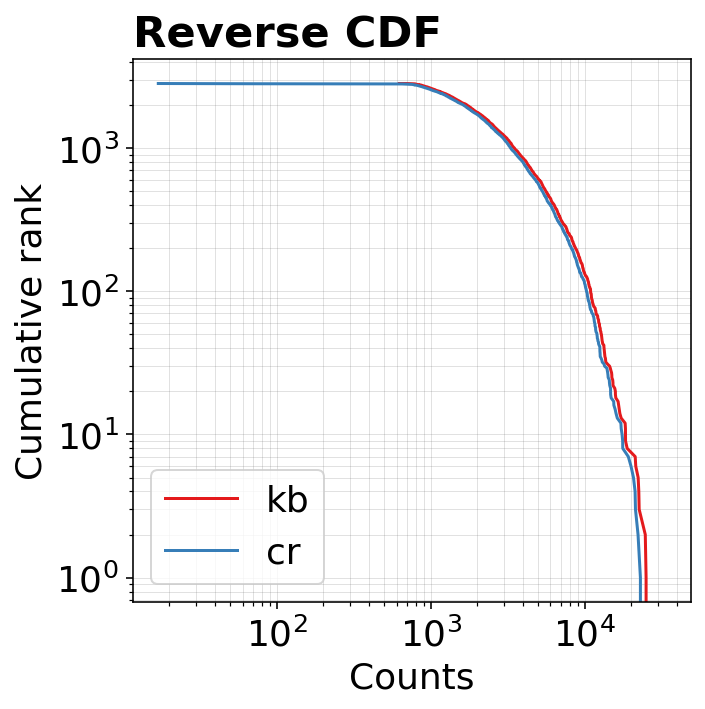

In [54]:
fig, ax = plt.subplots(figsize=(5,5))

x0,x1 = compare.rev_cdf(kb.X, cr.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors)

fig.show()

## pseudobulk

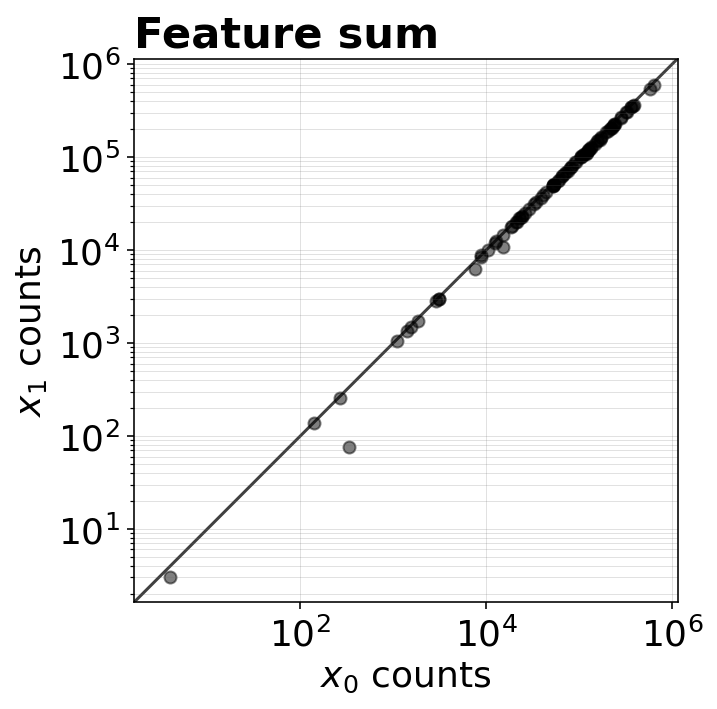

In [55]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cr.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

fig.show()

In [56]:
kb.var[(x0-x1).astype(int)<0]

,feature_name
feature_id,
CTNNB1-2,CTNNB1-2


In [57]:
# # kmer alignment index
# kallisto inspect -G gfa features.idx

# S       664     GGGCACTCGGCGGACGCAA     XT:S:EZR-2-1.2

# # Single sequence with two alignments
# AAGCAGTGGTATCAACGCAGAGTACATG GGGCACTCGGCGGACGCAA GGGGTTTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAAT
# AAGCAGTGGTATCAACGCAGAGTACATGGGG CACTCGGCGGACGCAAGGG GTTTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAAT

# # Problem BC 1 (EZR-1)
# EZR-1	        CACTCGGCGGACGCAA GGG
# EZR-2     GCG CACTCGGCGGACGCAA

# # Problem BC 1 (PPIB-2)
# PPIB-1   GGA GAGGCGCAGCATCCAC	
# PPIB-2       GAGGCGCAGCATCCAC AGG

# PPIB-2_rc CCTGTGGATGCTGCGC  

# # Protospacer sequence
# AAGCAGTGGTATCAACGCAGAGTACATGGGG -(BC)- GTTTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAAT

# Pseudobulk - cell

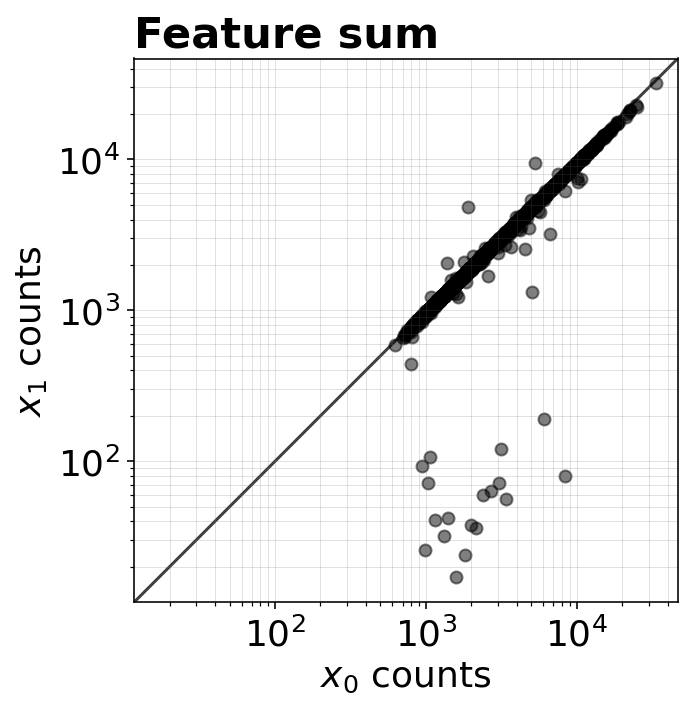

In [58]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cr.X, axis=1)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

fig.show()

# Feature correlation

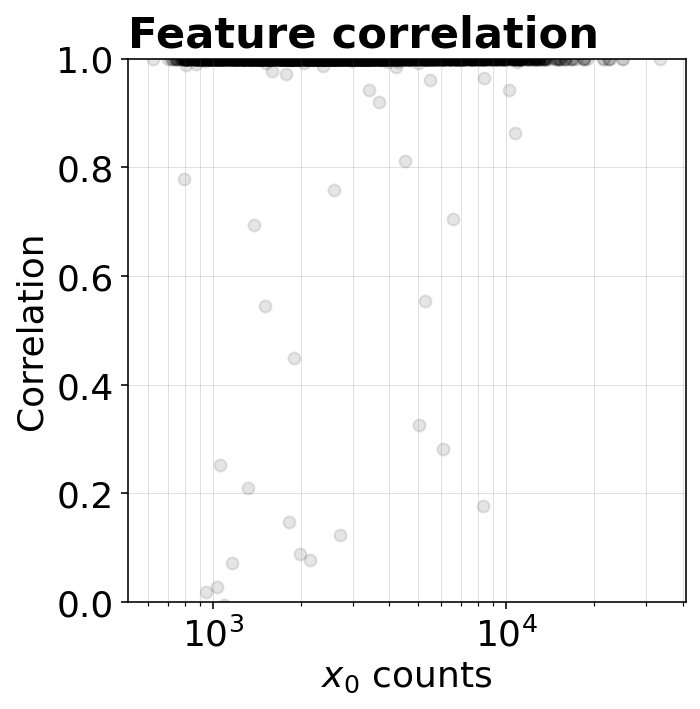

In [59]:
fig, ax = plt.subplots(figsize=(5,5))

x0, corr = compare.features_correlated(kb.X, cr.X)
plot.features_correlated(x0, corr, ax=ax)

fig.show()

### $l_1$ dist

In [60]:
# logged counts
XX_XY = compare.l1_distance(np.log1p(kb.X), np.log1p(cr.X))
YY_YX = compare.l1_distance(np.log1p(cr.X), np.log1p(kb.X))

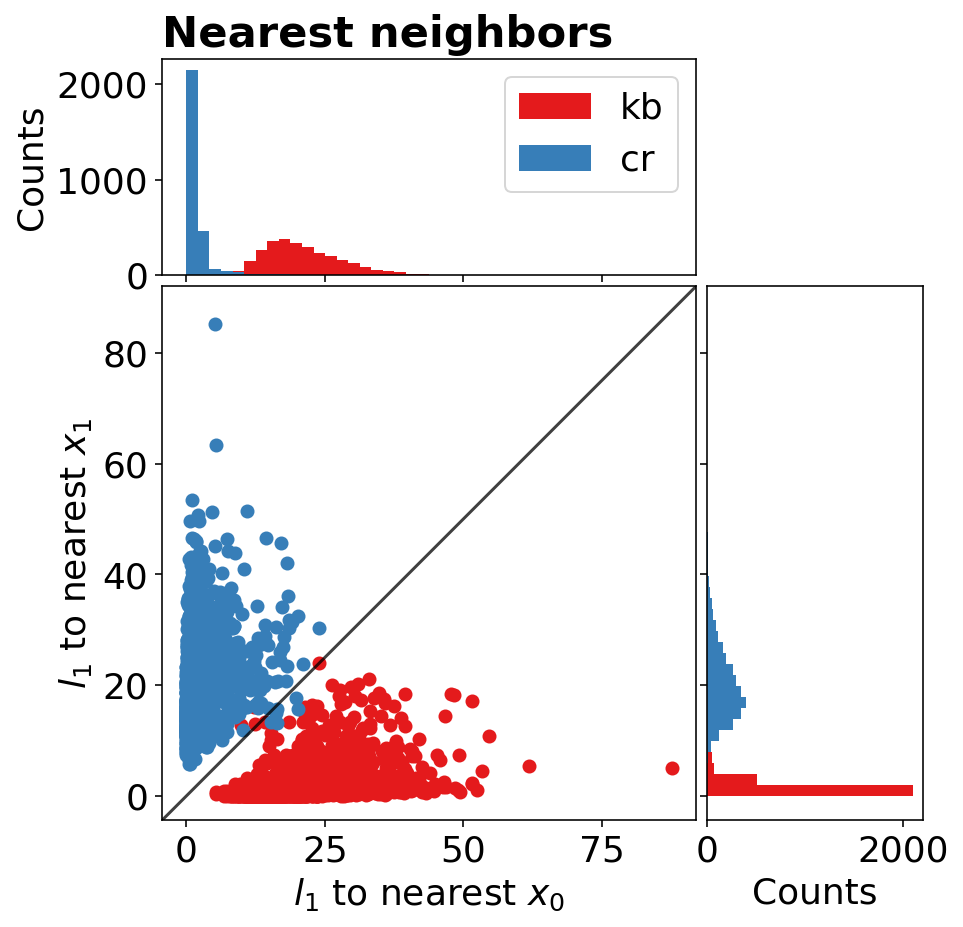

In [61]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                         ax=ax, 
                         labels=labels, 
                         colors=colors)

fig.show()

In [62]:
XX, XY = XX_XY
YY, YX = YY_YX

In [63]:
# logged counts
cnts = compare.sum_features(np.log1p(kb.X), axis=1)

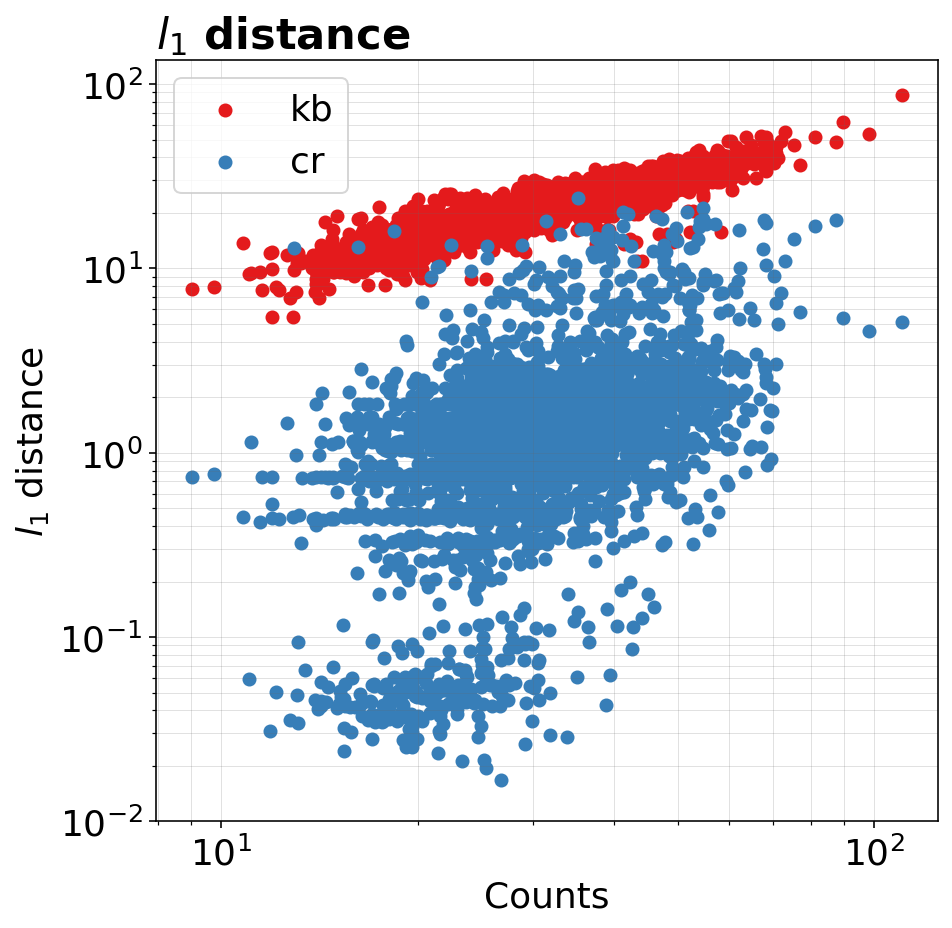

In [64]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_counts((cnts, XX), (cnts, XY), 
               ax=ax, 
               colors=colors,
               labels=labels)
ax.set(**{"ylim": 0.01})

fig.show()

---

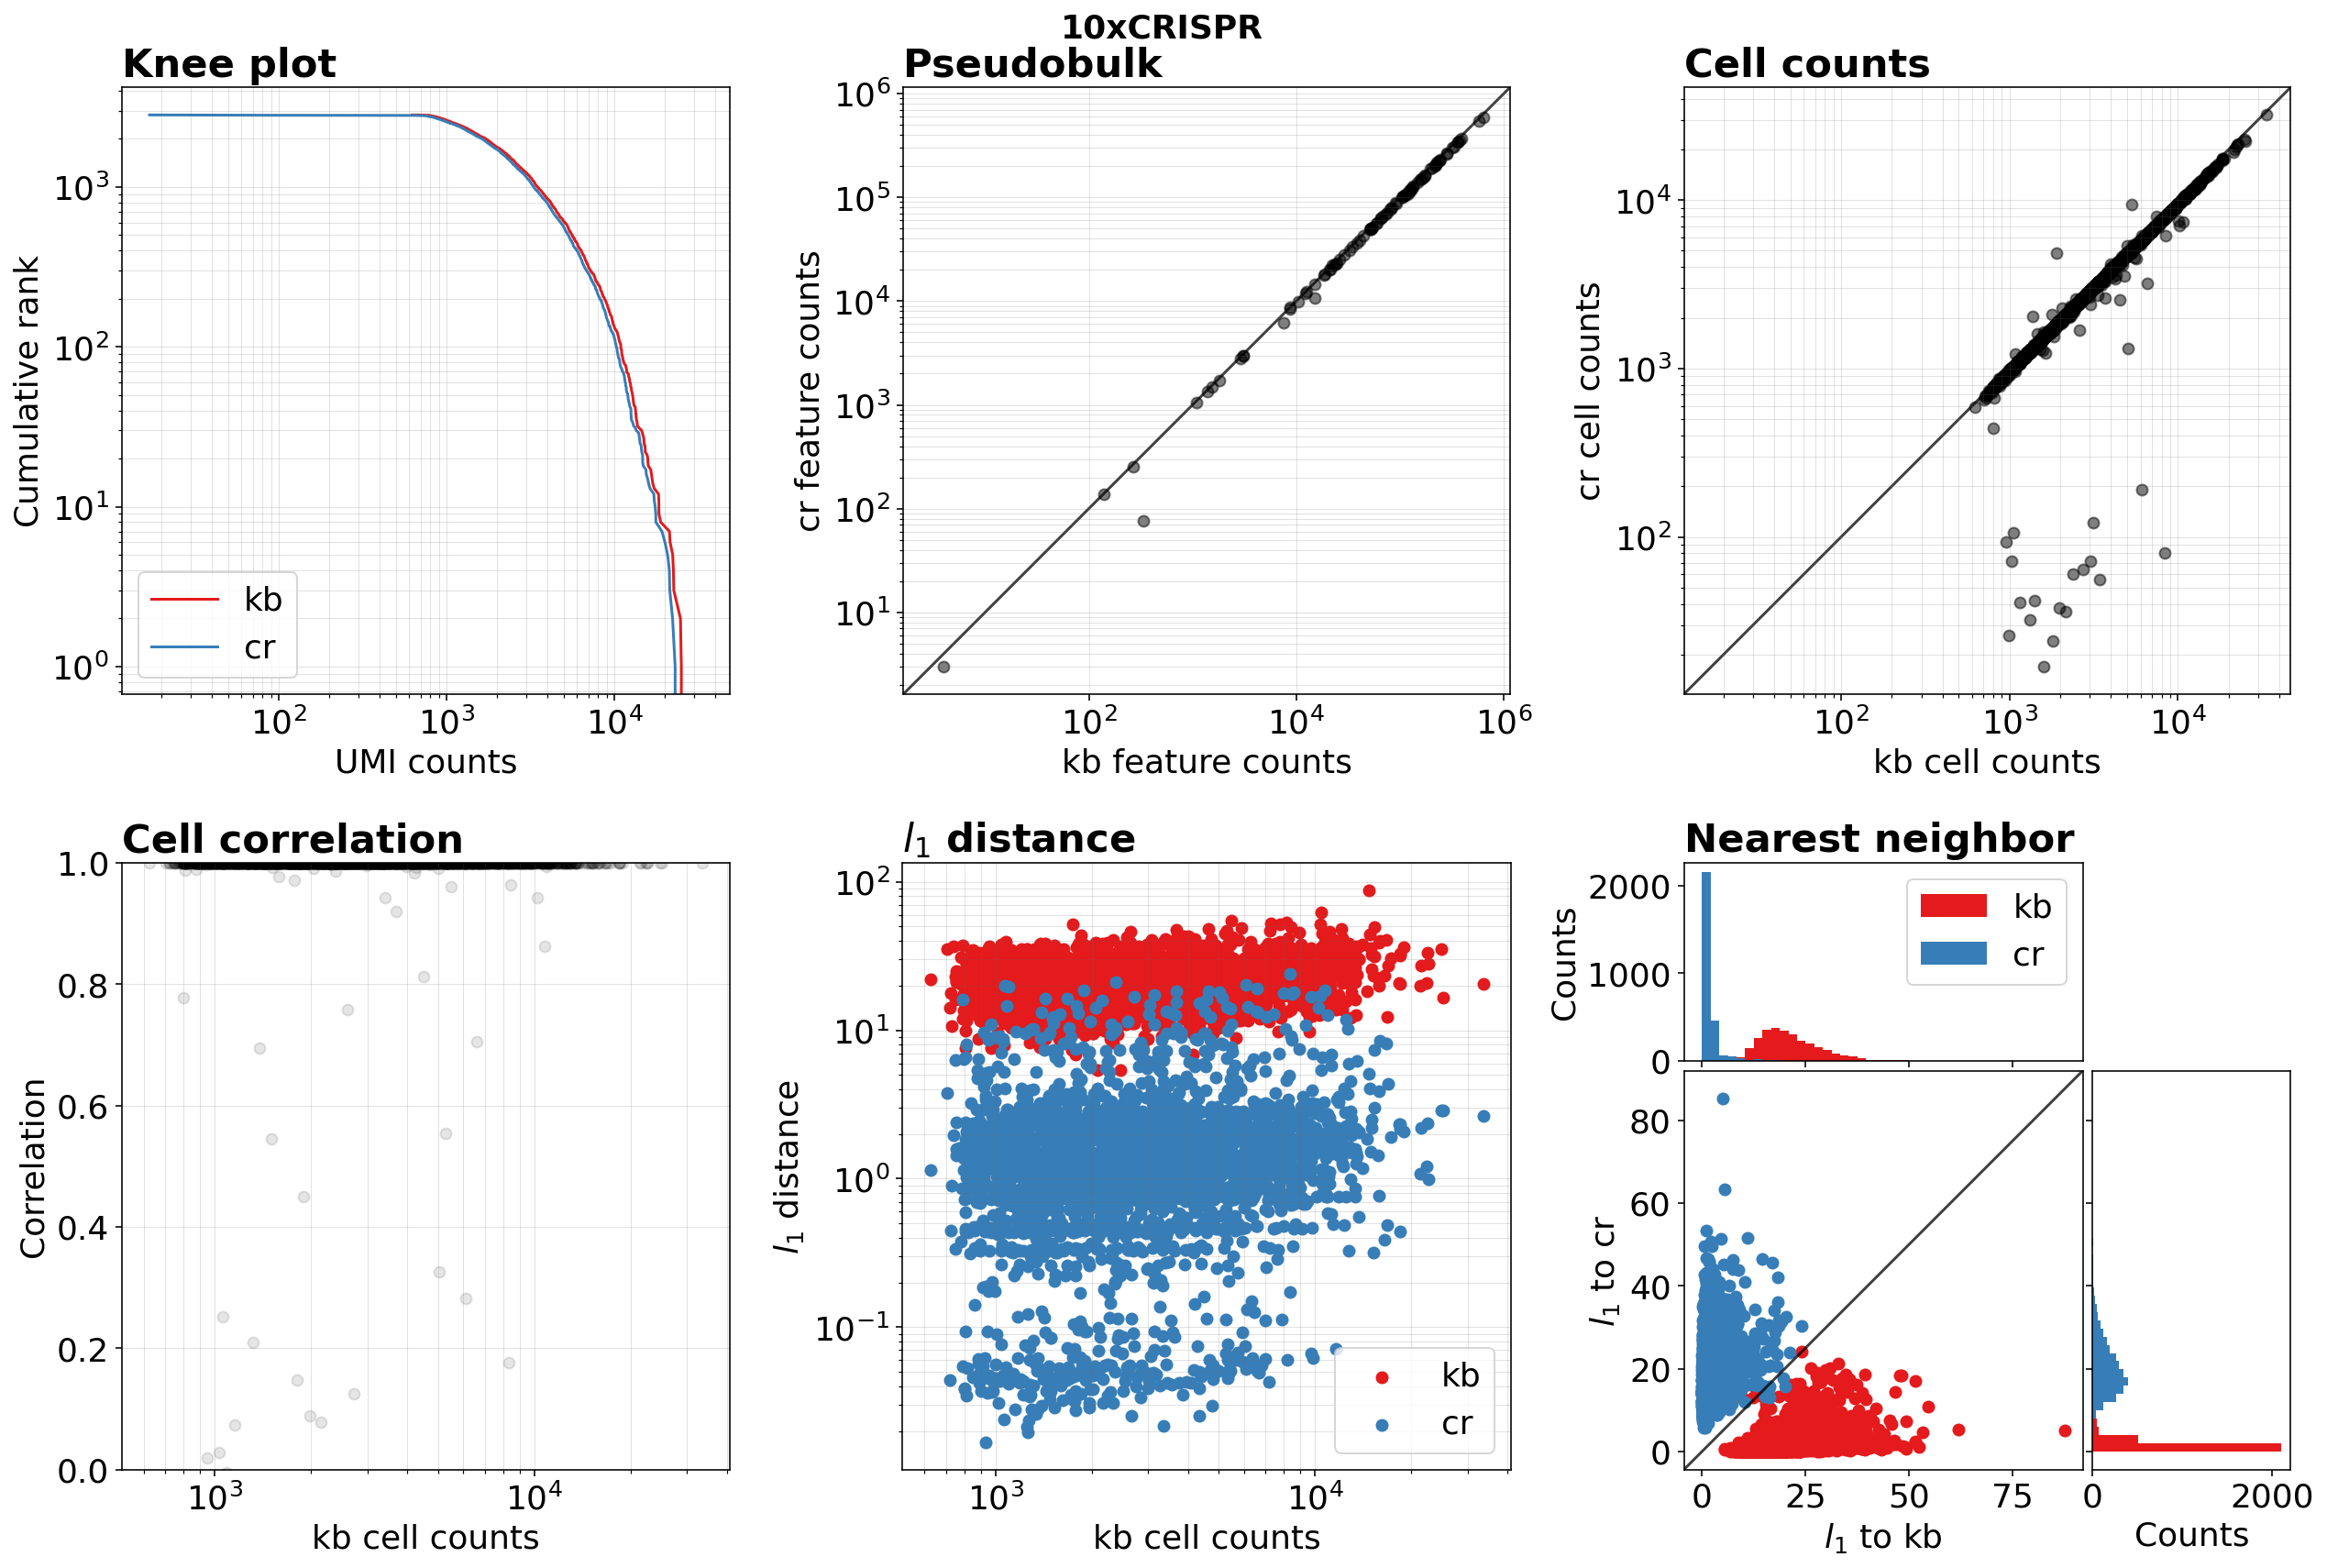

In [68]:
# Putting everything into one figure
row, col = (2, 3)
scale = 6

ds_name = "10xCRISPR"

fig, axs = plt.subplots(figsize=(col*scale, row*scale), nrows=row, ncols=col)
fig.suptitle(ds_name, fontweight='bold', fontsize = fsize, x=0.5, y=0.999)

# knee plot
ax = axs[0,0]

title = "a"
x0,x1 = compare.rev_cdf(kb.X, cr.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors, xlabel="UMI counts", title="Knee plot")


# pseudobulk
ax = axs[0,1]

title = "b"
x0, x1 = compare.cmp_sum(kb.X, cr.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5, xscale="log", yscale="log", xlabel=f"{labels[0]} feature counts", ylabel=f"{labels[1]} feature counts", title="Pseudobulk")
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# cell counts
ax = axs[0,2]

title = "c"
x0, x1 = compare.cmp_sum(kb.X, cr.X, axis=1)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5, xscale="log", yscale="log", xlabel=f"{labels[0]} cell counts", ylabel=f"{labels[1]} cell counts", title="Cell counts")


# features correlated
ax = axs[1,0]

title = "d"
x0, corr = compare.features_correlated(kb.X, cr.X)
plot.features_correlated(x0, corr, ax=ax, xlabel=f"{labels[0]} cell counts", title="Cell correlation")

# l1 counts
ax = axs[1,1]

title = "e"
cnts = compare.sum_features(kb.X, axis=1)
XX, XY = XX_XY
YY, YX = YY_YX

plot.l1_counts((cnts, XX), (cnts, XY), 
   ax=ax, 
   colors=colors,
   labels=labels,
   xlabel=f"{labels[0]} cell counts")

# nearest neighbor
ax = axs[1,2]

title = "f"
# note, taking log1p here
XX_XY = compare.l1_distance(np.log1p(kb.X), np.log1p(cr.X))
YY_YX = compare.l1_distance(np.log1p(cr.X), np.log1p(kb.X))
plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                 ax=ax, 
                 labels=labels, 
                 colors=colors,
                 xlabel=f"$l_1$ to {labels[0]}",
                 ylabel=f"$l_1$ to {labels[1]}",
                 title="Nearest neighbor")

fig.tight_layout()
fig.savefig("10xCRISPR.png", dpi=300, bbox_inches="tight")
fig.show()